# 0.0 Segment raw data and prepare syllables for analysis

> **Note:** this works for the recordings of a given year only

### This notebook does the following:
 - Segments raw recordings into manually defined songs 
 > saved as new .wav files and .json files with metadata
 - Segments songs into syllables 
 > saved as on-off times in each .json file
 

In [1]:
# Reload modules automatically
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import src
import glob
import joblib
from os import fspath

import warnings
warnings.filterwarnings(action="once")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import matplotlib.pyplot as plt
%matplotlib inline

from src.vocalseg.dynamic_thresholding import *
from src.avgn.dataset import DataSet
from src.avgn.utils.hparams import HParams
from src.avgn.utils.paths import most_recent_subdirectory
from tqdm.autonotebook import tqdm
from src.greti.read.paths import DATA_DIR, RESOURCES_DIR
from src.greti.audio.segmentation import *
from IPython import get_ipython
from IPython.display import display, HTML, display_html

/home/nilomr/projects/0.0_great-tit-song/src/avgn/utils/general.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# Set year
year = "2020"

In [4]:
# import recorded nestboxes
files_path = DATA_DIR / "raw" / year
filelist = np.sort(list(files_path.glob("**/*.WAV")))
recorded_nestboxes = pd.DataFrame(set([file.parent.name for file in filelist]))

# import the latest brood data downloaded from https://ebmp.zoo.ox.ac.uk/broods
brood_data_path = RESOURCES_DIR / "brood_data" / year
list_of_files = glob.glob(fspath(brood_data_path) + "/*.csv")
latest_file = max(list_of_files, key=os.path.getctime)
greti_nestboxes = pd.DataFrame(
    (pd.read_csv(latest_file).query('Species == "g"').filter(["Pnum"]))["Pnum"].str[5:]
)
# get those in both lists
recorded_gretis = [
    i
    for i in recorded_nestboxes.values.tolist()
    if i in greti_nestboxes.values.tolist()
]

print("You recorded a total of " + str(len(filelist)) + " hours of audio.")
print(
    "You recorded "
    + str(len(recorded_gretis))
    + " out of a total of "
    + str(len(greti_nestboxes))
    + " great tits that bred this year"
)

You recorded a total of 336 hours of audio.
You recorded 15 out of a total of 260 great tits that bred this year


### Segment raw recordings into bouts
 - Songs manually defined in AviaNZ - for now

> `batch_segment_bouts()` usis multiprocessing. If you run into problems, use `batch_segment_bouts_single()` (much slower).

In [5]:
origin = DATA_DIR / "raw" / year # Folder to segment
DT_ID = dt.datetime.now().strftime("%Y-%m-%d_%H-%M-%S") # Unique name for output folder
subset = "GRETI_HQ" # Name of label to select
DATASET_ID = "GRETI_HQ_2020" # Name of output dataset
threshold = 5000 # Amplitude threshold

In [7]:
batch_segment_songs(origin, DATA_DIR, DT_ID, DATASET_ID, subset=subset, threshold = threshold)

{Reading, trimming and saving songs}: 0it [00:00, ?it/s]Complete
total time (s)= 0.11338949203491211

{Reading, trimming and saving songs}: 100%|██████████| 30/30 [00:00<00:00, 5559.30it/s]
Complete
total time (s)= 52.61744546890259
{Reading, trimming and saving songs}: 100%|██████████| 34/34 [00:00<00:00, 15307.68it/s]
Complete
total time (s)= 43.01444149017334
{Reading, trimming and saving songs}: 100%|██████████| 38/38 [00:00<00:00, 22090.58it/s]
Complete
total time (s)= 41.19578289985657
{Reading, trimming and saving songs}: 100%|██████████| 24/24 [00:00<00:00, 4331.28it/s]
Complete
total time (s)= 12.15490436553955
{Reading, trimming and saving songs}: 100%|██████████| 41/41 [00:00<00:00, 6144.73it/s]
Complete
total time (s)= 53.550737142562866
{Reading, trimming and saving songs}: 100%|██████████| 27/27 [00:00<00:00, 15761.48it/s]
Complete
total time (s)= 96.37318062782288
{Reading, trimming and saving songs}: 100%|██████████| 40/40 [00:00<00:00, 14231.25it/s]
Complete
total time

- Let's check how many songs have been exported:

In [6]:

all_songs_path = most_recent_subdirectory(DATA_DIR / 'processed' / DATASET_ID)
all_songs_list = np.sort(list(all_songs_path.glob('**/*.wav')))
print('There are ' + str(len(all_songs_list)) + ' songs')


There are 1108 songs


# Syllable segmentation

### Create dataset

In [7]:

# Dataset label
DATASET_ID = "GRETI_HQ_2020"

# datetime identifier for output folder
DT_ID = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
DT_ID

# Define parameters
hparams = HParams(
    n_fft=1024,
    win_length_ms=4,
    hop_length_ms=3,
    mel_lower_edge_hertz=1200,
    mel_upper_edge_hertz=10000,
    butter_lowcut=1200,
    butter_highcut=10000,
    ref_level_db=30,
    min_level_db=-30,
    n_jobs=-2,
    verbosity=1,
    nex=-1,
)


In [8]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams=hparams)

# Check a sample json
dataset.sample_json

    unclosed file <_io.TextIOWrapper name='/home/nilomr/projects/0.0_great-tit-song/test/processed/GRETI_HQ_2020/2020-09-12_11-07-53/JSON/MP48-GRETI_HQ-20200429_060000-54.wav.JSON' mode='r' encoding='UTF-8'>


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    6.0s


[Parallel(n_jobs=-2)]: Done 1044 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-2)]: Done 1094 out of 1107 | elapsed:    7.0s remaining:    0.1s
[Parallel(n_jobs=-2)]: Done 1107 out of 1107 | elapsed:    7.0s finished


    can't resolve package from __spec__ or __package__, falling back on __name__ and __path__


OrderedDict([('species', 'GRETI_HQ'),
             ('nestbox', 'MP48'),
             ('indvs',
              OrderedDict([('MP48', OrderedDict([('species', 'GRETI_HQ')]))])),
             ('recorder', '247AA5075E063642'),
             ('recordist', 'Nilo Merino Recalde'),
             ('source_datetime', '2020-04-29 06:00:00'),
             ('datetime', '2020-04-29 06:35:21.485196'),
             ('date', '2020-04-29'),
             ('time', '06:35:21.485196'),
             ('timezone', 'UTC'),
             ('samplerate_hz', 48000),
             ('length_s', 1.5510416666666667),
             ('lower_freq', 2831),
             ('upper_freq', 4729),
             ('max_amplitude', 5514.0),
             ('min_amplitude', -5115.0),
             ('bit_depth', 16),
             ('tech_comment',
              'Recorded at 06:00:00 29/04/2020 (UTC) by AudioMoth 247AA5075E063642 at gain setting 3 while battery state was 3.9V.'),
             ('source_loc',
              '/home/nilomr/projects/0.

### Define parameters

In [98]:
# Segmentation parameters
parameters = {
    "n_fft": 1024,
    "hop_length_ms": 3,
    "win_length_ms": 10,
    "ref_level_db": 30,
    "pre": 0.5,
    "min_level_db": -25,
    "min_level_db_floor": -20,
    "db_delta": 8,
    "silence_threshold": 0.2,
    "min_silence_for_spec": 0.001,
    "max_vocal_for_spec": (0.4,),
    "min_syllable_length_s": 0.03,
    "spectral_range": [1200, 10000],
}

# There needs to be a silence of at least min_silence_for_spec length,
# and a syllable no longer than max_vocal_for_spec length

### Check a sample song

    unclosed file <_io.BufferedReader name=51>
    unclosed file <_io.BufferedReader name=55>


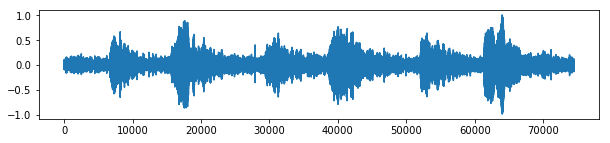

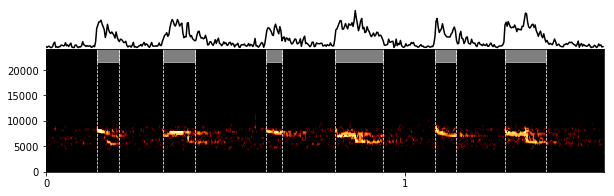

In [99]:
rate, data = load_wav(dataset.sample_json["wav_loc"])
butter_min = dataset.sample_json["lower_freq"]
butter_max = dataset.sample_json["upper_freq"]
data = butter_bandpass_filter(data, butter_min, butter_max, rate)
data = librosa.util.normalize(data)

plt.figure(figsize=(10.05, 2))
plt.plot(data)

results = dynamic_threshold_segmentation(data, rate, **parameters)

plot_segmentations(
    results["spec"],
    results["vocal_envelope"],
    results["onsets"],
    results["offsets"],
    hop_length_ms=3,
    rate=rate,
    figsize=(10, 3),
)

plt.show()

### Test segmentation in a subset of the data

In [87]:
indvs = np.array(["_".join(list(i)) for i in dataset.json_indv])
np.unique(indvs)
len(np.unique(indvs))

15

B175


    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.273
longest vocalization 0.25500000000000006


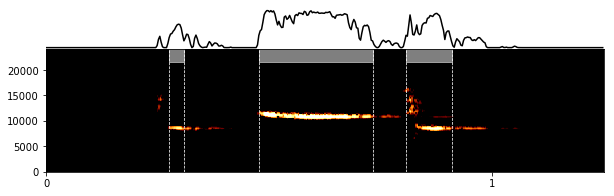

    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.465
longest vocalization 0.123


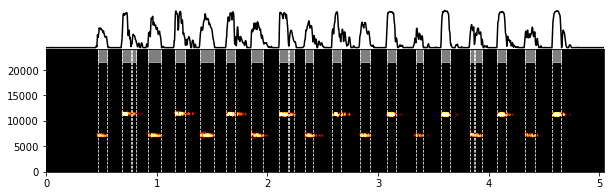

    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.19500000000000006
longest vocalization 0.14400000000000013


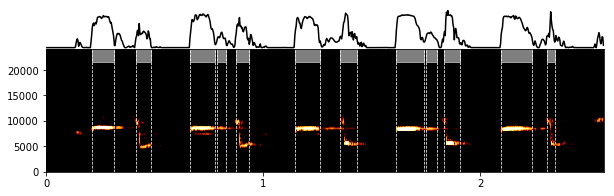

    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.2489999999999999
longest vocalization 0.23400000000000004


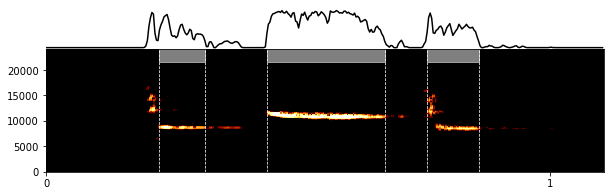

    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.738
longest vocalization 0.18900000000000006


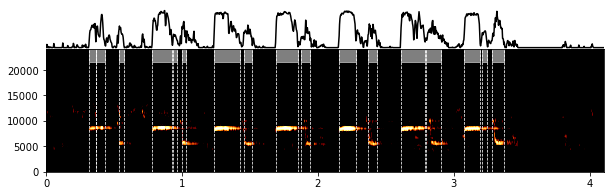

B181


C126


C25


    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.3420000000000001
longest vocalization 0.16499999999999992


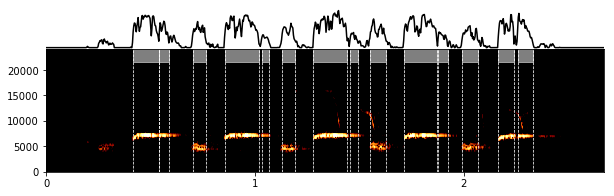

    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.447
longest vocalization 0.14100000000000007


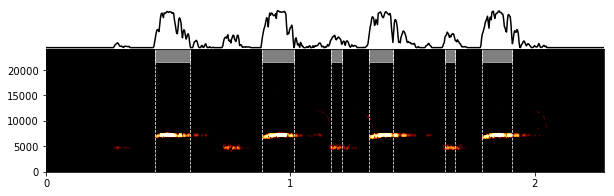

    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.47100000000000003
longest vocalization 0.16799999999999998


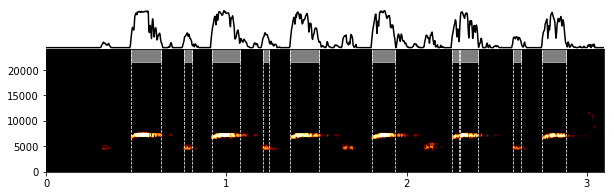

    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.42300000000000004
longest vocalization 0.15000000000000002


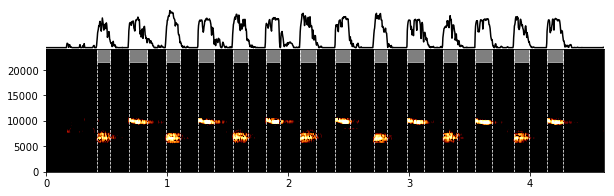

    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.24600000000000002
longest vocalization 0.16199999999999992


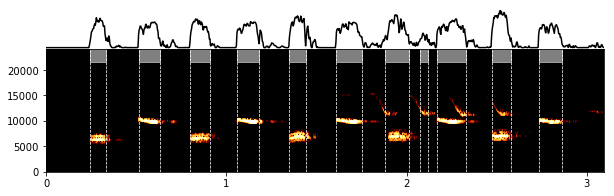

C51


    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.49200000000000005
longest vocalization 0.22499999999999998


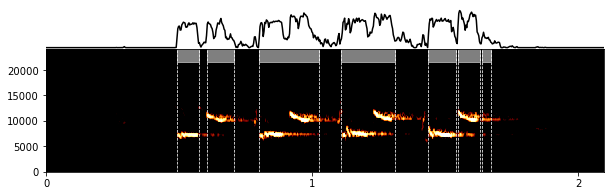

    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.4289999999999998
longest vocalization 0.15000000000000013


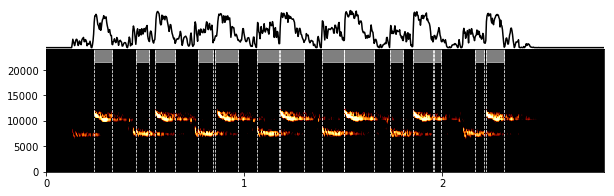

    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.36300000000000004
longest vocalization 0.1319999999999999


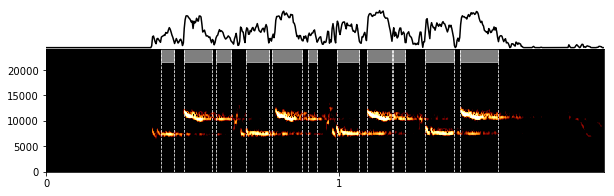

    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.54
longest vocalization 0.15000000000000002


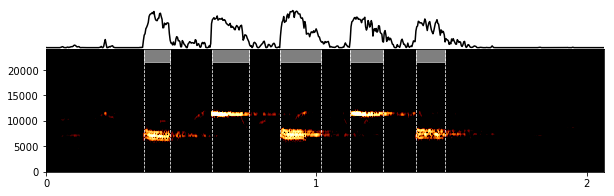

    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.48000000000000004
longest vocalization 0.11699999999999999


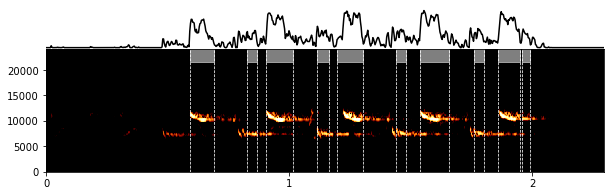

C61A


EX120


    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.201
longest vocalization 0.09899999999999998


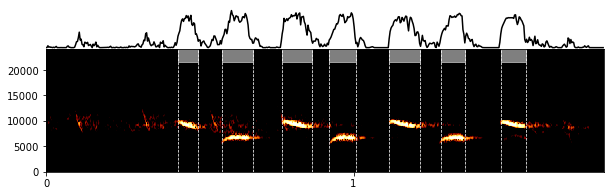

    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.20700000000000002
longest vocalization 0.09899999999999998


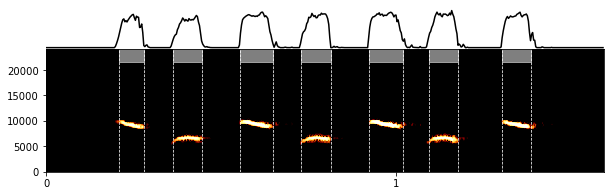

    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.525
longest vocalization 0.10200000000000009


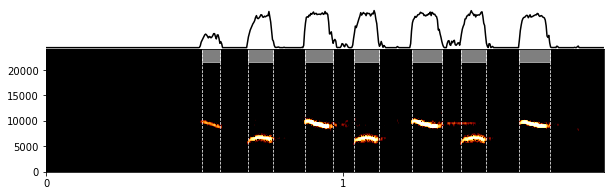

    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.387
longest vocalization 0.0990000000000002


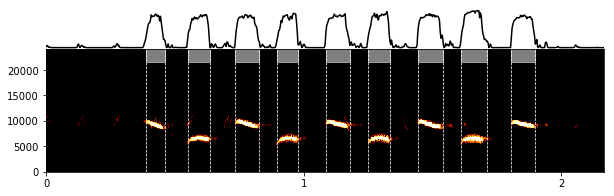

    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.33
longest vocalization 0.09299999999999997


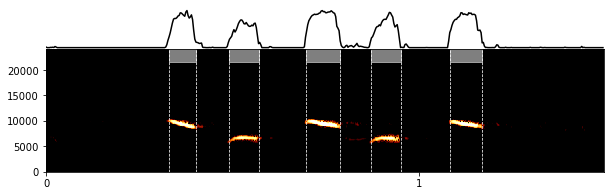

EX14


    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.28500000000000003
longest vocalization 0.15600000000000003


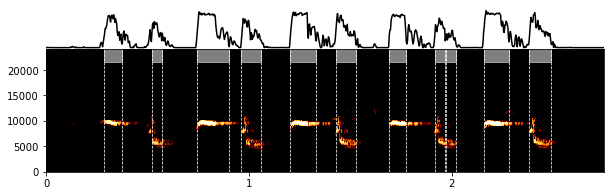

    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.35700000000000004
longest vocalization 0.135


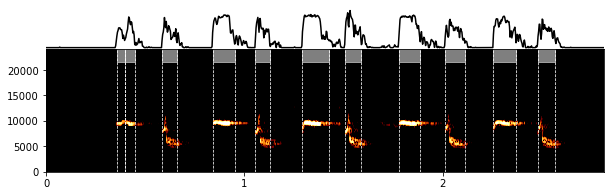

    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.3780000000000001
longest vocalization 0.15300000000000002


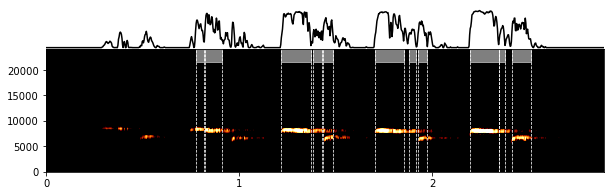

    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.5010000000000003
longest vocalization 0.18599999999999994


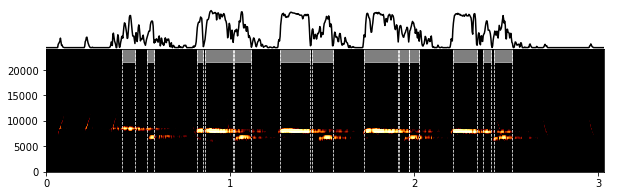

    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.49200000000000005
longest vocalization 0.18900000000000006


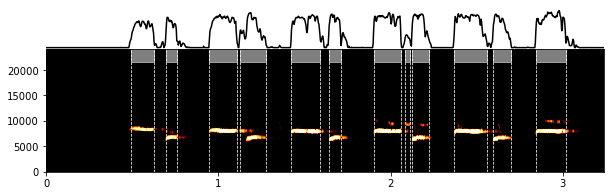

EX65


EX74


MP2


MP48


    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.18599999999999994
longest vocalization 0.0930000000000002


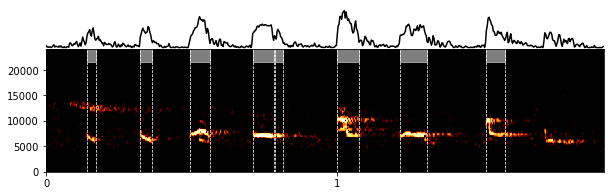

    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.4980000000000002
longest vocalization 0.10499999999999998


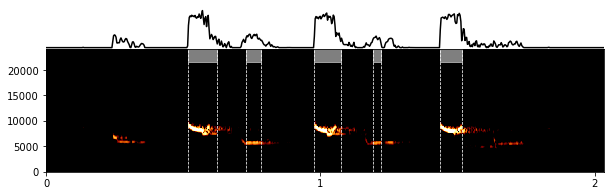

    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.174
longest vocalization 0.11399999999999999


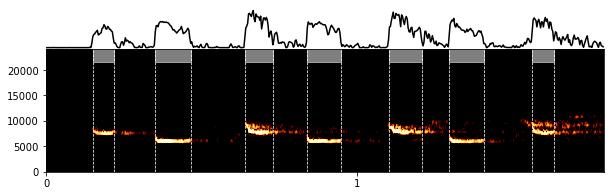

    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.20999999999999996
longest vocalization 0.08099999999999996


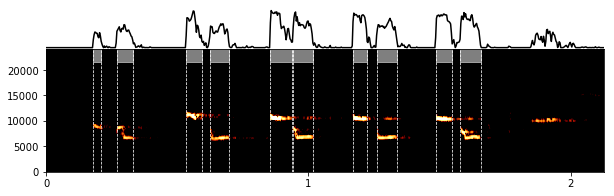

    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.22199999999999998
longest vocalization 0.11100000000000021


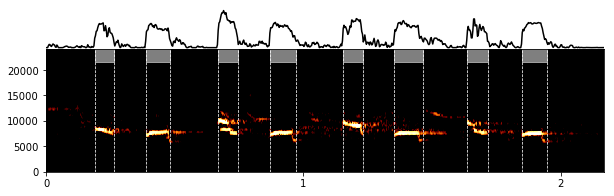

O80


O86


W77


    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.201
longest vocalization 0.11399999999999999


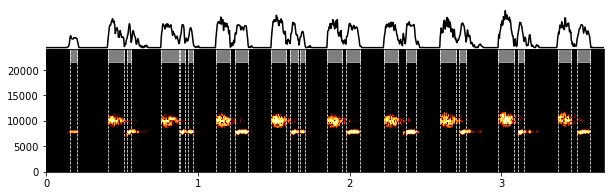

    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.18299999999999983
longest vocalization 0.11699999999999999


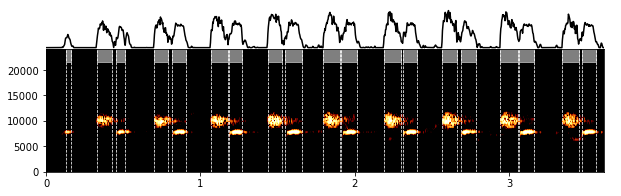

    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.18000000000000005
longest vocalization 0.09599999999999997


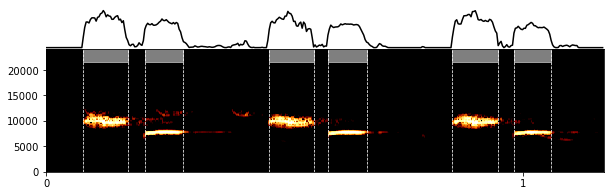

    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.219
longest vocalization 0.10200000000000031


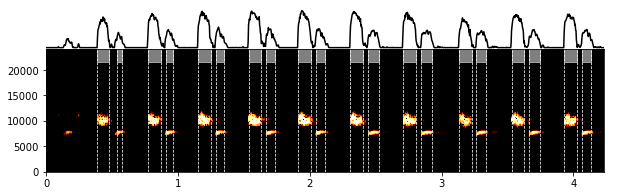

    unclosed file <_io.BufferedReader name=44>
    unclosed file <_io.BufferedReader name=54>


longest silence 0.18900000000000006
longest vocalization 0.11099999999999999


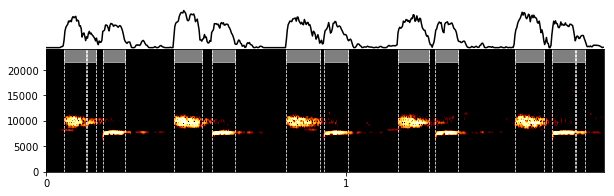

In [100]:

for indv in tqdm(np.unique(indvs), desc="individuals"):
    print(indv)
    indv_keys = np.array(list(dataset.data_files.keys()))[indvs == indv][20:25]

    joblib.Parallel(n_jobs=1, verbose=0)(
        joblib.delayed(segment_spec_custom)(
            key, dataset.data_files[key], **parameters, DT_ID=DT_ID, DATASET_ID=DATASET_ID, plot=True
        )
        for key in tqdm(indv_keys, desc="files", leave=False)
    )

### Segment full dataset

In [101]:
nex = -1
for indv in tqdm(np.unique(indvs), desc="individuals"):
    print(indv)
    indv_keys = np.array(list(dataset.data_files.keys()))[indvs == indv]

    joblib.Parallel(n_jobs=-2, verbose=1)(
        joblib.delayed(segment_spec_custom)(
            key, 
            dataset.data_files[key], 
            **parameters,
            DT_ID=DT_ID, 
            DATASET_ID=DATASET_ID, 
            save=True
        )
        for key in tqdm(indv_keys, desc="files", leave=False)
    )

B175


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    6.1s


B181


[Parallel(n_jobs=-2)]: Done  59 out of  59 | elapsed:    7.7s finished


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


C126


[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    0.3s finished


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


C25


[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    0.4s finished


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


C51


[Parallel(n_jobs=-2)]: Done  28 out of  28 | elapsed:    2.4s finished


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.1s


C61A


[Parallel(n_jobs=-2)]: Done 107 out of 107 | elapsed:    8.4s finished


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


EX120


[Parallel(n_jobs=-2)]: Done   4 out of   4 | elapsed:    0.5s finished


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


EX14


[Parallel(n_jobs=-2)]: Done  28 out of  28 | elapsed:    2.1s finished


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:   15.9s


EX65


[Parallel(n_jobs=-2)]: Done 367 out of 367 | elapsed:   30.7s finished


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   7 | elapsed:    0.5s remaining:    1.1s


EX74


[Parallel(n_jobs=-2)]: Done   7 out of   7 | elapsed:    0.7s finished


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


MP2


[Parallel(n_jobs=-2)]: Done  12 out of  12 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  12 out of  12 | elapsed:    1.1s finished


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


MP48


[Parallel(n_jobs=-2)]: Done  14 out of  14 | elapsed:    1.2s finished


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.0s


O80


[Parallel(n_jobs=-2)]: Done 102 out of 102 | elapsed:    8.1s finished


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.8s


O86


[Parallel(n_jobs=-2)]: Done   7 out of   7 | elapsed:    0.7s finished


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


W77


[Parallel(n_jobs=-2)]: Done   4 out of   4 | elapsed:    0.4s finished


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:   16.2s


[Parallel(n_jobs=-2)]: Done 366 out of 366 | elapsed:   33.2s finished
